ceated by Noriko Etani, June 12, 2021.

**時系列解析SARIMAモデルによる日本のCOVID-19感染予測**

日本の「ワクチン2回目接種者数」，日本および人口密度の高い3大都市「東京都」「大阪府」「神奈川県」の「新規感染者数予測」と「新規死亡者数予測」を行う実験．

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
#必要なモジュールの準備
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline
sns.set()
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import matplotlib.dates as dates
import datetime as dt
from datetime import datetime
import matplotlib.dates as mdates
import math

**1. Data read**

In [43]:
place = 'Japan'
outday = '0817'

In [44]:
csv_fname = "/content/drive/MyDrive/TimeLineData/"+place+"_"+outday+".csv"


In [45]:
#Specify date as index 
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')

In [46]:
#Each csv file read
death = pd.read_csv(csv_fname, index_col='date', date_parser=dateparse, dtype='float', usecols=["date", "new_deaths"])
patient = pd.read_csv(csv_fname, index_col='date', date_parser=dateparse, dtype='float', usecols=["date", "new_cases"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [ ]:
#our world in dataから抽出するので1日遅延するため個別入力とする
vaccinated = pd.read_csv("/content/drive/MyDrive/TimeLineData/Japan_0816.csv", index_col='date', date_parser=dateparse, dtype='float', usecols=["date", "people_fully_vaccinated2"])

In [47]:
#Read data on the number of new deaths 
ts1 = death['new_deaths']
#Read data on the number of new infected people
ts2 = patient['new_cases']

In [ ]:
#Read data on the number of people fully vaccinated
ts3 = vaccinated['people_fully_vaccinated2']

**2. Data ploting**

**ワクチン2回接種者数推移**

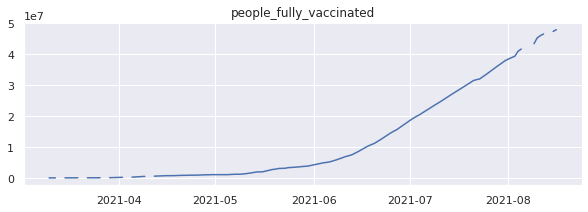

In [ ]:
#people_fully_vaccinated
plt.figure(figsize=(10, 3))   # (width, height)
plt.title("people_fully_vaccinated")
plt.plot(ts3)
#our world in dataから抽出するので1日遅延するため個別入力とする
#fname = place + "_vaccinated_" + outday + ".jpg"
#plt.savefig(fname)
plt.savefig('Japan_vaccinated_0816.jpg')

**新規死亡者数推移（移動平均7日も表示）**

色指定：b ⇒ blue, 青 g ⇒ green, 緑 r ⇒ red, 赤 c ⇒ cyan, シアン m ⇒ magenta, 赤紫 y ⇒ yellow, 黄色 k ⇒ black, 黒（これだけ頭文字ではない） w ⇒ white, 白

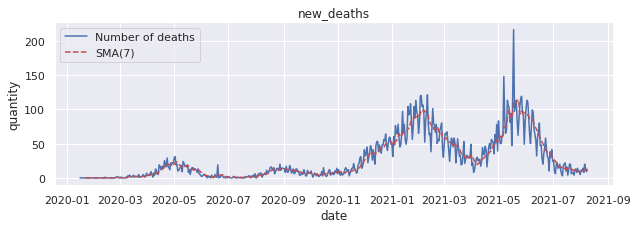

In [ ]:
#death
# 移動平均 SMA(Simple Moving Average)
#df["3ma"]=df["Passengers"].rolling(3).mean().round(1)
#df["5ma"]=df["Passengers"].rolling(5).mean().round(1)
#df["7ma"]=df["Passengers"].rolling(7).mean().round(1)
#death["3ma"]=ts1.rolling(3).mean().round(1)
#death["5ma"]=ts1.rolling(5).mean().round(1)
death["7ma"]=ts1.rolling(7).mean().round(1)
#death["10ma"]=ts1.rolling(10).mean().round(1)

# 可視化
plt.figure(figsize=(10,4))   # (width, height)
plt.title("new_deaths")
plt.plot(ts1, label="Number of deaths")
#plt.plot(death["3ma"], "k--", label="SMA(3)")  #black
#plt.plot(death["5ma"], "r--", label="SMA(5)")  #red
plt.plot(death["7ma"], "r--", label="SMA(7)")  #green
#plt.plot(death["10ma"], "r--", label="SMA(10)") #cyan
plt.xlabel("date")
plt.ylabel("quantity")
plt.legend()
fname = place + "_death_SMA_" + outday + ".jpg"
plt.savefig(fname)
#plt.savefig('KANAGAWA_death_SMA_0731.jpg')
plt.show()

**新規感染者数推移（移動平均7日も表示）**

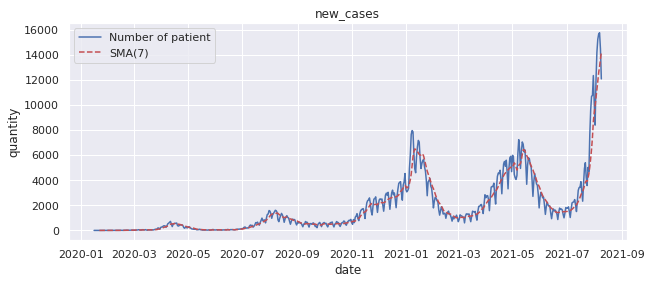

In [ ]:
#patient
# 移動平均
#df["3ma"]=df["Passengers"].rolling(3).mean().round(1)
#df["5ma"]=df["Passengers"].rolling(5).mean().round(1)
#df["7ma"]=df["Passengers"].rolling(7).mean().round(1)
#patient["3ma"]=ts2.rolling(3).mean().round(1)
#patient["5ma"]=ts2.rolling(5).mean().round(1)
patient["7ma"]=ts2.rolling(7).mean().round(1)
#patient["10ma"]=ts2.rolling(10).mean().round(1)

# 可視化
plt.figure(figsize=(10,4))   # (width, height)
plt.title("new_cases")
plt.plot(ts2, label="Number of patient")
#plt.plot(patient["3ma"], "k--", label="SMA(3)")
#plt.plot(patient["5ma"], "r--", label="SMA(5)")
plt.plot(patient["7ma"], "r--", label="SMA(7)")
#plt.plot(patient["10ma"], "r--", label="SMA(10)")
plt.xlabel("date")
plt.ylabel("quantity")
plt.legend()
fname = place + "_patient_SMA_" + outday + ".jpg"
plt.savefig(fname)
#plt.savefig('KANAGAWA_patient_SMA_0731.jpg')
plt.show()

In [ ]:
#patient_7 = patient["7ma"].fillna(0)

**3. Data analysis**

**（１）加法モデルと乗法モデルの選択**

現系列を基本成分「傾向動向（トレンド）」「季節変動」「残差 (不規則変動 = 誤差変動 + 特異的変動)」に分解

・傾向動向：時間とともに単調に増加/減少する変動

・季節変動：季節によって左右される1年を周期として規則的に繰り返される変動。ここでは、同じサイクルで繰り返される日変動のような固定的な変動を同様に扱う。

・不規則変動：上記以外の説明がつかない不規則かつ短期間に起こる小変動。

https://blog.amedama.jp/entry/sm-decompose-series


<Figure size 360x432 with 0 Axes>

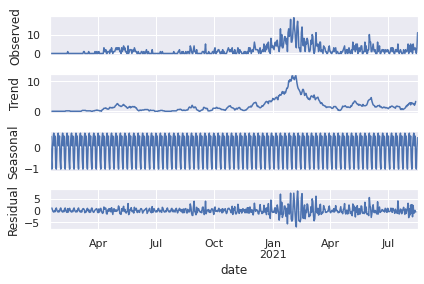

In [ ]:
#death
#現系列を基本成分に分解する
#トレンド、季節性、残差 (不規則変動 = 誤差変動 + 特異的変動)に分解
res = sm.tsa.seasonal_decompose(ts1)
#plt.figure(figsize=(20,10))   # (width, height)
plt.figure(figsize=(5, 6))   # (width, height)
fig = res.plot()
fname = place + "_death_decompose_" + outday + ".jpg"
plt.savefig(fname)

<Figure size 360x432 with 0 Axes>

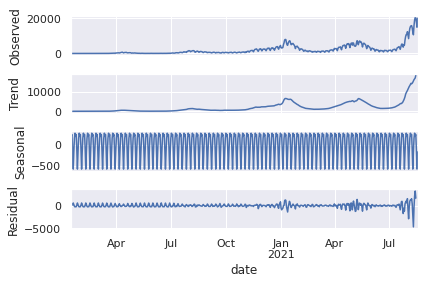

In [60]:
#patient
#トレンド、季節性、残差に分解
res = sm.tsa.seasonal_decompose(ts2)
#plt.figure(figsize=(20, 10))   # (width, height)
plt.figure(figsize=(5, 6))   # (width, height)
fig = res.plot()
fname = place + "_patient_decompose_" + outday + ".jpg"
plt.savefig(fname)

加法モデルは観測値が大きいときも小さいときも、固定した量の季節成分の値が加算されるだけなので、季節変動の幅は一定である。ここでは7日間サイクルで繰り返されていることが明確である。次の作図よりSeasonalを拡大して，その周期性を確認する．

**（２）周期性の確認**

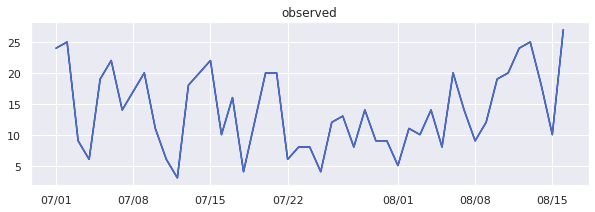

In [57]:
#death
#observedを抽出
ts1_1 = ts1.loc['2021/7/1':'2021/8/16']
res1_1 = sm.tsa.seasonal_decompose(ts1_1)
#plt.figure(figsize=(15, 5))
fig, ax = plt.subplots(figsize=(10, 3))
plt.title("observed")

res1_1.index = pd.to_datetime(ts1_1.index)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.plot(res1_1.index,res1_1.observed,color = "blue")

plt.plot(res1_1.observed)
# y=val(**月1日の値）に水平線を引く
fname = place + "_death_observed_" + outday + ".jpg"
plt.savefig(fname)

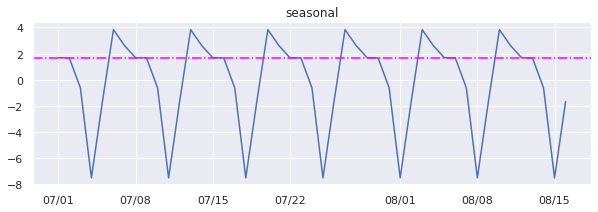

In [58]:
#death
#seasonalを抽出
val = res1_1.seasonal[0]
#plt.figure(figsize=(15, 5))
fig, ax = plt.subplots(figsize=(10, 3))
plt.title("seasonal")

res1_1.index = pd.to_datetime(ts1_1.index)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.plot(res1_1.index,res1_1.seasonal)

#plt.plot(res1_1.seasonal)
# y=val(**月1日の値）に水平線を引く
plt.axhline(val, ls = "-.", color = "magenta")
fname = place + "_death_seasonal_" + outday + ".jpg"
plt.savefig(fname)

In [ ]:
res1_1.seasonal.to_csv("./death_seasonal.csv",index=False)

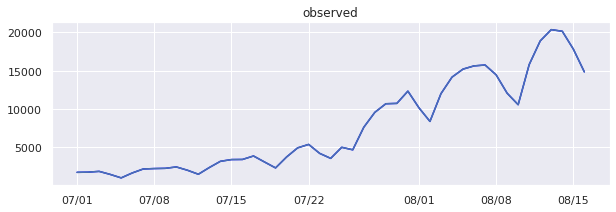

In [59]:
#patient
#observedを抽出
ts2_1 = ts2.loc['2021/7/1':'2021/8/16']
res2_1 = sm.tsa.seasonal_decompose(ts2_1)
#plt.figure(figsize=(15, 5))
fig, ax = plt.subplots(figsize=(10, 3))
plt.title("observed")

res2_1.index = pd.to_datetime(ts2_1.index)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.plot(res2_1.index,res2_1.observed,color = "blue")

plt.plot(res2_1.observed)
# y=val(**月1日の値）に水平線を引く
fname = place + "_death_observed_" + outday + ".jpg"
plt.savefig(fname)

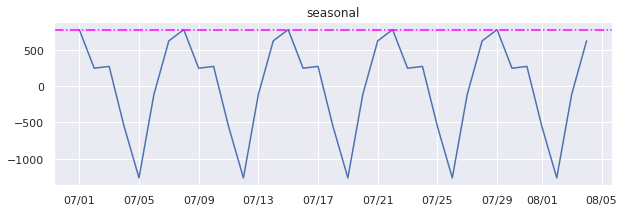

In [53]:
#patient
#seasonalを抽出
val = res2_1.seasonal[0]
#plt.figure(figsize=(15, 5))
fig, ax = plt.subplots(figsize=(10, 3))
plt.title("seasonal")

res2_1.index = pd.to_datetime(ts2_1.index)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.plot(res2_1.index,res2_1.seasonal)

#plt.plot(res1_1.seasonal)
# y=val(**月1日の値）に水平線を引く
plt.axhline(val, ls = "-.", color = "magenta")
fname = place + "_death_seasonal_" + outday + ".jpg"
plt.savefig(fname)

In [ ]:
res2_1.seasonal.to_csv("./patient_seasonal.csv",index=False)

**※時系列データに周期性、つまり季節成分が含まれるか調べる方法**

分解する前の原系列（観測値）と分解した後の差分(Residual)について自己相関(Autocorrelation)と偏自己相関(Partial autocorrelation)を計算してグラフにプロット（コレログラム）している。

自己相関係数（ACF:Autocorrelation Function）： 自己相関係数とは、過去の値とどれほど似ているのか（相関があるのか）を表す指標

偏自己相関係数（PACF, partial autocorrelation function）： 偏自己相関係数は、自己相関係数と同じように過去の値とどれほど似ているのか（相関があるのか）を表す指標。ただし、推移関係を排除した、例えば、先月の値と先々月の値の関係性を調べるためには、先月の影響を除去した自己相関係数を調べる方法が必要となる。推移関係を排除した自己相関係数を偏自己相関係数と呼ぶ。

https://blog.amedama.jp/entry/sm-decompose-series

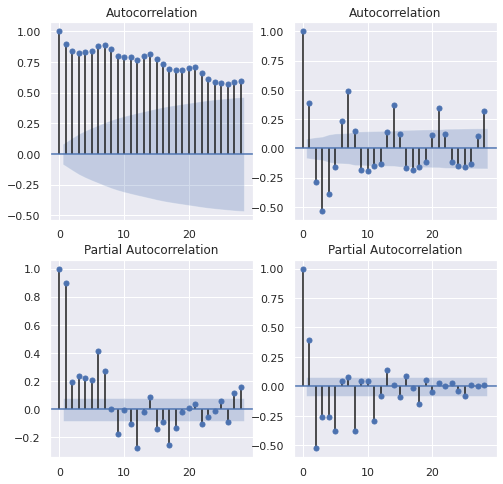

In [ ]:
#death
#コレログラム
#ACF stands for Auto Correlation Function and PACF stands for Partial Auto Correlation Function.
#_, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 7))
# 原系列の ACF
sm.tsa.graphics.plot_acf(ts1, ax=axes[0][0])
# 原系列の PACF
sm.tsa.graphics.plot_pacf(ts1, ax=axes[1][0])

# 差分の ACF
sm.tsa.graphics.plot_acf(res.resid.dropna(), ax=axes[0][1])
# 差分の PACF
sm.tsa.graphics.plot_pacf(res.resid.dropna(), ax=axes[1][1])

# グラフを表示する
fname = place + "_death_ACFPACF_" + outday + ".jpg"
plt.savefig(fname)
plt.show()

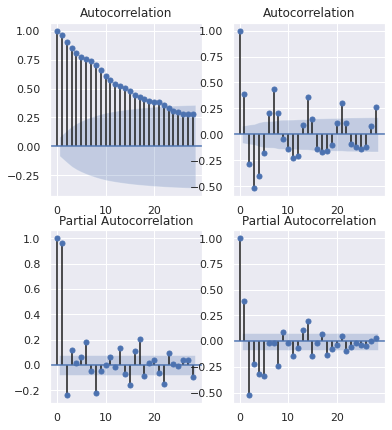

In [ ]:
#patient
#コレログラム
#_, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
_, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 7))
# 原系列の ACF
sm.tsa.graphics.plot_acf(ts2, ax=axes[0][0])
# 原系列の PACF
sm.tsa.graphics.plot_pacf(ts2, ax=axes[1][0])

# 差分の ACF
sm.tsa.graphics.plot_acf(res.resid.dropna(), ax=axes[0][1])
# 差分の PACF
sm.tsa.graphics.plot_pacf(res.resid.dropna(), ax=axes[1][1])

# グラフを表示する
fname = place + "_patient_ACFPACF_" + outday + ".jpg"
plt.savefig(fname)
plt.show()

左側が原系列（観測値），右側が差分について計算したもの． 青い帯は「相関がない」を帰無仮説とした 95% 信頼区間を表している． つまり，帯の外にある値は 5% の有意水準で相関があることになる． 原系列の偏自己相関も差分の偏自己相関も，ラグ 1 以外に相関がある箇所は見当たらない． つまり，季節変動を取り除くことができていることになる．

**（３）ADF検定：データの定常性・単位根の確認**

帰無仮説『単位根（非定常性）である』は，P値5%以下であるので帰無仮説を放棄し，データに定常性があると判断する．

In [ ]:
#ts1:death  ts2:patient
diff = ts1.diff()
diff = diff.dropna()

# トレンド項あり（１次まで）、定数項あり
ct = sm.tsa.stattools.adfuller(diff, regression="ct")
# トレンド項なし、定数項あり
c = sm.tsa.stattools.adfuller(diff, regression="c")
# トレンド項なし、定数項なし
nc = sm.tsa.stattools.adfuller(diff, regression="nc")

print("ct:")
print(ct[1])
print("---------------------------------------------------------------------------------------------------------------")
print("c:")
print(c[1])
print("---------------------------------------------------------------------------------------------------------------")
print("nc:")
print(nc[1])
print("---------------------------------------------------------------------------------------------------------------")

ct:
0.46470976287789767
---------------------------------------------------------------------------------------------------------------
c:
0.20506073697952742
---------------------------------------------------------------------------------------------------------------
nc:
0.03266111055416638
---------------------------------------------------------------------------------------------------------------


**4. Creating SARIMA model**

ARIMAモデルは，3つのパラメータを持ちます．

①AR(自己回帰)モデルにおける「回帰数」

②差分を取る「回数」．ここでの差分とは、時系列データにおいて隣り合うデータの差分である．ここでは定常性のあるデータとするために1回の差分を取るので「1」を設定する．

③MA(移動平均)モデルにおける「平均を計算する際に考慮するデータ数」

**（１）差分計算**

残差は1回とると定常性のあるデータ

In [ ]:
#death
#差分データ計算
diff1 = ts1.diff()
diff1 = diff1.dropna() # NaN要素を削除

In [ ]:
#patient
#差分データ計算
diff2 = ts2.diff()
diff2 = diff2.dropna() # NaN要素を削除

**（２）StatsModelsによるARMAモデルの最適パラメータ自動選択**

sm.tsa.arma_order_select_ic(input_Ts, ic='aic', trend='nc')

'aic_min_order':上記①「回帰数」と③「平均を計算する際に考慮するデータ数」の値となる


In [ ]:
#death
#statsmodelsを用いて、上記①と③の値を計算
params1 = sm.tsa.arma_order_select_ic(diff1, ic='aic', trend='nc')

In [ ]:
params1

{'aic':              0            1            2
 0          NaN  2434.622896  2407.680096
 1  2559.859661  2412.003565  2409.672932
 2  2531.328955  2403.311179  2374.074200
 3  2494.019618  2384.129321  2358.746652
 4  2445.935870  2365.773191  2346.141265, 'aic_min_order': (4, 2)}

In [ ]:
#patient
#statsmodelsを用いて、上記①と③の値を計算
params2 = sm.tsa.arma_order_select_ic(diff2, ic='aic', trend='nc')

In [ ]:
params2

{'aic':              0            1            2
 0          NaN  6651.114778  6652.477644
 1  6654.616638  6652.106015  6653.848693
 2  6654.104451  6653.677454  6655.573819
 3  6655.535792  6655.142643  6613.336424
 4  6653.746200  6652.774004  6555.082960, 'aic_min_order': (4, 2)}

**（３）ARIMA modelの作成**

ARIMAモデルを構築できるかの確認．"LinAlgError: SVD did not converge"というエラーが発生しても，ここを飛ばして（４）へ進んでください．

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
#death
#ARIMAモデル構築(aic1)
#tsは対象となる時系列データです。そのあとのorderパラメータが、上記1.、2.、3.のパラメータになります。
arima_model1 = ARIMA(ts1, order=(4,1,2)).fit(dist=False)

In [ ]:
#patient
#ARIMAモデル構築(aic1)
#tsは対象となる時系列データです。そのあとのorderパラメータが、上記1.、2.、3.のパラメータになります。
arima_model2 = ARIMA(ts2, order=(4,1,2)).fit(dist=False)

**（４）SARIMA model：seasonal_orderの最適パラメータ自動選択**

seasonal_orderというパラメータが追加されています．このパラメータは4つの引数を持ちます． 4つ目の値(ここでは「7」)が周期が発生する間隔です．

https://www.wisdomgeek.com/development/machine-learning/sarima-forecast-seasonal-data-using-python/

In [ ]:
import itertools
 
# 各パラメータの範囲を決める
p = d = q = range(0, 3)
sp = sd = sq = range(0, 2)
 
# p, d, q　の組み合わせを列挙するリストを作成
pdq = list(itertools.product(p, d, q))
 
# P, D, Q　の組み合わせを列挙するリストを作成すると同時に、後ろに　s = 12　を決め打ちでつけている。
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(sp, sd, sq))]


In [ ]:
pdq[0:6]

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2)]

In [ ]:
#ts1:death  ts2:patient
import warnings
warnings.simplefilter('ignore')

p = range(0, 3)
d = range(1,2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

best_param = [0,0,0]
best_param_seasonal = [0,0,0,0]
best_aic = 100000
#for param in pdq:
param = (4,1,2)
for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts2,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
            if best_aic > results.aic:
               best_param = param
               best_param_seasonal = param_seasonal
               best_aic = results.aic
        except:
            continue
print('*BEST ARIMA{}x{}7 - AIC:{}'.format(best_param, best_param_seasonal, best_aic))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 1) x (0, 1, 1, 7)
SARIMAX: (0, 1, 1) x (0, 1, 2, 7)
SARIMAX: (0, 1, 2) x (1, 1, 0, 7)
SARIMAX: (0, 1, 2) x (1, 1, 1, 7)
ARIMA(4, 1, 2)x(0, 1, 0, 7)7 - AIC:6419.447459033176
ARIMA(4, 1, 2)x(0, 1, 1, 7)7 - AIC:6274.056709424816
ARIMA(4, 1, 2)x(0, 1, 2, 7)7 - AIC:6190.584891374331
ARIMA(4, 1, 2)x(1, 1, 0, 7)7 - AIC:6273.6086376958065
ARIMA(4, 1, 2)x(1, 1, 1, 7)7 - AIC:6244.010394592957
ARIMA(4, 1, 2)x(1, 1, 2, 7)7 - AIC:6197.038120343621
ARIMA(4, 1, 2)x(2, 1, 0, 7)7 - AIC:6202.936902289735
ARIMA(4, 1, 2)x(2, 1, 1, 7)7 - AIC:6200.036929133752
ARIMA(4, 1, 2)x(2, 1, 2, 7)7 - AIC:6204.713084594168
*BEST ARIMA(4, 1, 2)x(0, 1, 2, 7)7 - AIC:6190.584891374331


**（５）SARIMA modelの作成**

In [ ]:
#death
#SARIMAモデル構築
#SARIMAモデルは、ARIMAモデルに「季節的な周期パターン」を加えたモデル
sarima_model1 = sm.tsa.SARIMAX(ts1, order=(4,1,2), seasonal_order=(2,1,1,7)).fit()

In [ ]:
#patient
#SARIMAモデル構築
#SARIMAモデルは、ARIMAモデルに「季節的な周期パターン」を加えたモデル
sarima_model2 = sm.tsa.SARIMAX(ts2, order=(4,1,2), seasonal_order=(0,1,2,7)).fit()

**5. Prediction by SARIMA model**

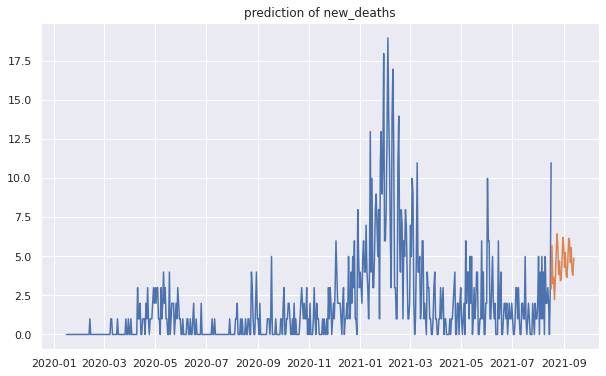

In [ ]:
#death
#構築したモデルに基づいて予測
predict = sarima_model1.predict('2021-08-17', '2021-09-13')
plt.figure(figsize=(10, 6))   # (width, height)
plt.title("prediction of new_deaths")
plt.plot(ts1) # 実データをプロット
plt.plot(predict) # 予測データをプロット
fname = place + "_death_pred_" + outday + ".jpg"
plt.savefig(fname)

In [ ]:
fname = place + "_death_pred_" + outday + ".csv"
predict.to_csv(fname,index=False)

In [ ]:
max(predict)

6.449843877412746

In [ ]:
#少数点以下切り上げ
math.ceil(max(predict))

7

In [ ]:
min(predict)

2.2246355058347067

In [ ]:
if ((min(predict)) <= 0):
   print("0")
else:
   print(math.ceil(min(predict)))

3


In [ ]:
#new_deathsが"0"となるdate取得
len = predict.shape[0]
for w in range(len):
    if(predict[w] <= 0):
       print(predict.index[w])
       print (predict[w])
       break

2021-08-09 00:00:00
-0.0694312229000712


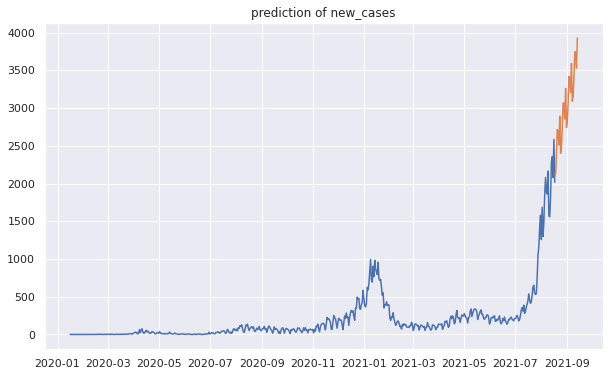

In [ ]:
#patient
#構築したモデルに基づいて予測
predict = sarima_model2.predict('2021-08-17', '2021-09-13')
plt.figure(figsize=(10, 6))   # (width, height)
plt.title("prediction of new_cases")
#plt.figure(figsize=(20, 5))   # (width, height)
plt.plot(ts2)  # 実データをプロット
plt.plot(predict)  # 予測データをプロット
fname = place + "_patient_pred_" + outday + ".jpg"
plt.savefig(fname)


In [ ]:
fname = place + "_patient_pred_" + outday + ".csv"
predict.to_csv(fname,index=False)

In [ ]:
max(predict)

3929.1578461083454

In [ ]:
#少数点以下切り上げ
math.ceil(max(predict))

3930

In [ ]:
min(predict)

2116.792842467563

In [ ]:
if ((min(predict)) <= 0):
   print("0")
else:
   print(math.ceil(min(predict)))

2117


In [ ]:
#new_casesが"0"となるdate取得
len = predict.shape[0]
for w in range(len):
    if(predict[w] <= 0):
       print(predict.index[w])
       print (predict[w])
       break

**6. Plotting prediction**

新規感染者数予測および新規死亡者数予測における最大値と最小値を観察日と観察値に合わせて作図します．

・新規死亡者数の予測最大値と最小値のファイル（death_pred.csv）を読み込む

・新規感染者数の予測最大値と最小値のファイル（patient_pred.csv）を読み込む


In [ ]:
death_fname = "/content/drive/MyDrive/TimeLineData/death_pred.csv"
patient_fname = "/content/drive/MyDrive/TimeLineData/patient_pred.csv"

In [ ]:
max_value = "max_"+place
min_value = "min_"+place

In [ ]:
#Each csv file read
death_max = pd.read_csv(death_fname, index_col='date', date_parser=dateparse, dtype='float', usecols=["date", max_value])
death_min = pd.read_csv(death_fname, index_col='date', date_parser=dateparse, dtype='float', usecols=["date", min_value])
patient_max = pd.read_csv(patient_fname, index_col='date', date_parser=dateparse, dtype='float', usecols=["date", max_value])
patient_min = pd.read_csv(patient_fname, index_col='date', date_parser=dateparse, dtype='float', usecols=["date", min_value])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [ ]:
#Read data on the number of new deaths 
pred1_max = death_max[max_value]
pred1_min = death_min[min_value]
#Read data on the number of new infected people
pred2_max = patient_max[max_value]
pred2_min = patient_min[min_value]

新規死亡者数の予測値と観測値を作図

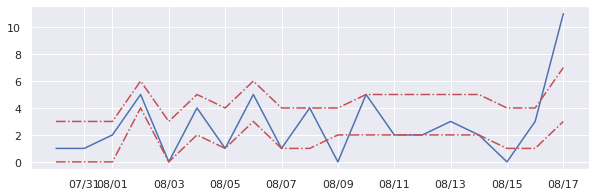

In [ ]:
#death
ts1_p = ts1.loc['2021/7/30':'2021/8/17']
#ts1_sma7 = ts1.loc['2021/7/24':'2021/8/16']
#7SMA
#death["7ma"]=ts1_sma7.rolling(7).mean().round(1)

#fig, ax = plt.subplots(figsize=(10, 6))
#fig, ax = plt.subplots(figsize=(10, 4))
fig, ax = plt.subplots(figsize=(10, 3))
start_datetime1 = datetime(2021, 7,30)
end_datetime1 = datetime(2021, 8,17)

ts1_p.index = pd.to_datetime(ts1_p.index)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.plot(ts1_p.index,ts1_p)
ax.plot(pred1_max, "r-.")
ax.plot(pred1_min, "r-.")
#7SMA
#ax.plot(death["7ma"], "g--", label="SMA(7)") 

#ax.axvspan(start_datetime1, end_datetime1, color="green", alpha=0.3)

fname = place + "_death_predzone_" + outday + ".jpg"
plt.savefig(fname)

新規感染者数の予測値と観測値を作図

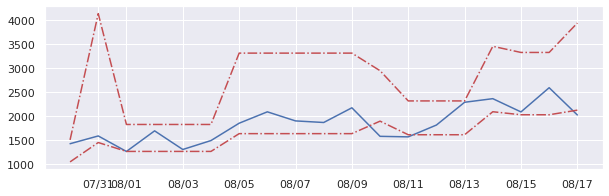

In [ ]:
#patient
ts2_p = ts2.loc['2021/7/30':'2021/8/17']
#ts2_sma7 = ts2.loc['2021/7/24':'2021/8/16']
#7SMA
#patient["7ma"]=ts2_sma7.rolling(7).mean().round(1)

#fig, ax = plt.subplots(figsize=(10, 6))
#fig, ax = plt.subplots(figsize=(10, 4))
fig, ax = plt.subplots(figsize=(10, 3))
start_datetime1 = datetime(2021, 7,30)
end_datetime1 = datetime(2021, 8,17)

ts1_p.index = pd.to_datetime(ts1_p.index)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.plot(ts2_p)
ax.plot(pred2_max, "r-.")
ax.plot(pred2_min, "r-.")
#7SMA
#plt.plot(patient["7ma"], "g--", label="SMA(7)")

#ax.axvspan(start_datetime1, end_datetime1, color="green", alpha=0.3)

fname = place + "_patinet_predzone_" + outday + ".jpg"
plt.savefig(fname)